Duplicate timestamps before handling: DatetimeIndex([], dtype='datetime64[ns, UTC+05:30]', name='date', freq=None)
Number of duplicate timestamps after handling: 0
Accuracy: 0.51
Precision: 0.51
Recall: 0.74


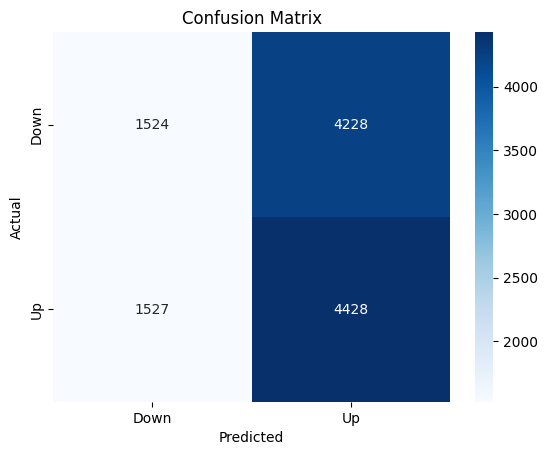

Cumulative Returns: 71.57%
Max Drawdown: 0.21%
Sharpe Ratio: 0.48
Out-of-Sample Accuracy: 0.47
Out-of-Sample Precision: 0.47
Out-of-Sample Recall: 0.73

Model Performance Summary
Accuracy          : 50.84%
Precision         : 51.16%
Recall            : 74.36%
Sharpe Ratio      : 0.48
Max Drawdown      : 20.77%
Cumulative Returns: 71.57%


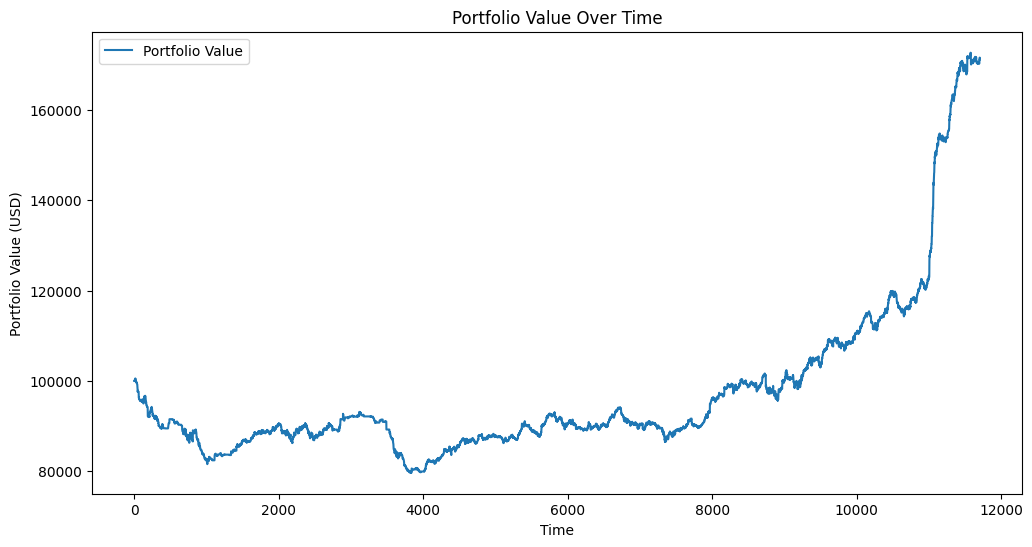

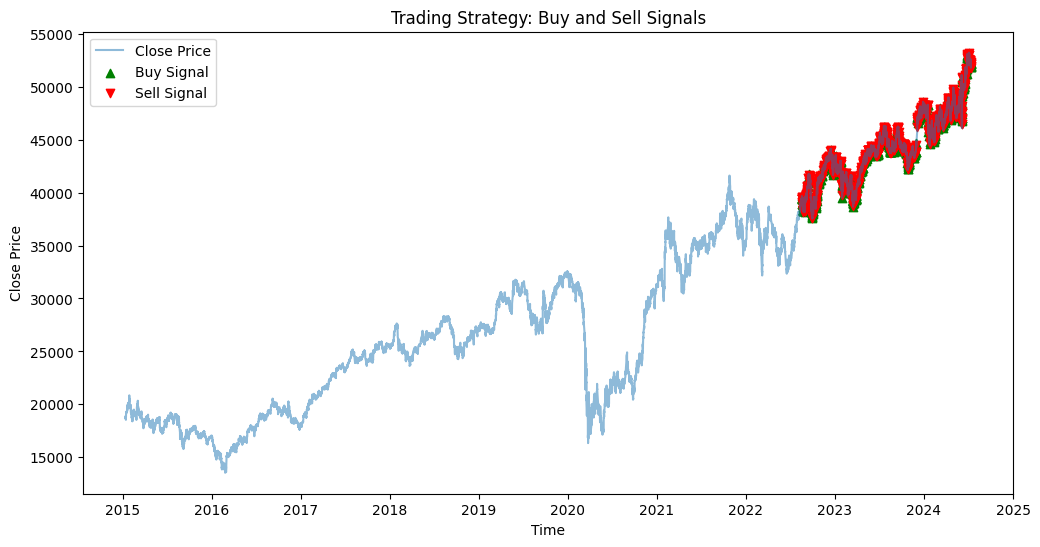

Training Set Performance:
Accuracy: 0.56
Precision: 0.55
Recall: 0.64

Validation Set Performance (Test Set):
Accuracy: 0.51
Precision: 0.51
Recall: 0.74

Out-of-Sample Performance:
Out-of-Sample Accuracy: 0.47
Out-of-Sample Precision: 0.47
Out-of-Sample Recall: 0.73

Cumulative Returns: 0.01%
Sharpe Ratio: -0.67
Max Drawdown: 0.00%
Accuracy: 0.51
Precision: 0.51
Recall: 0.74


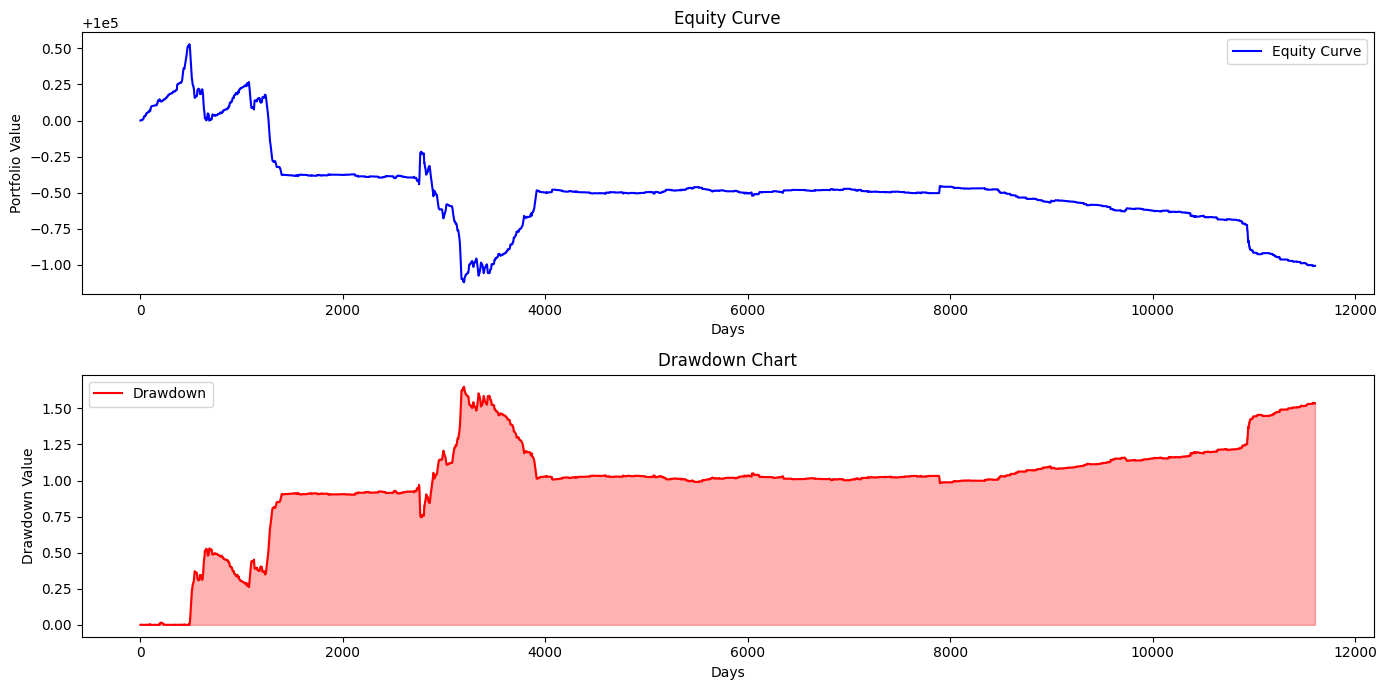

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_path = './../datasets/quant/portfolio-universe/Indian/NIFTY BANK/NIFTY BANK_15m.csv'
data = pd.read_csv(data_path, parse_dates=['date'], index_col='date')

duplicate_timestamps = data.index[data.index.duplicated()].unique()
print(f'Duplicate timestamps before handling: {duplicate_timestamps}')

data = data[~data.index.duplicated(keep='first')]

print(f'Number of duplicate timestamps after handling: {data.index.duplicated().sum()}')

data = data[['open', 'high', 'low', 'close', 'volume']]

data['sma_20'] = data['close'].rolling(window=20).mean()
data['sma_50'] = data['close'].rolling(window=50).mean()
data['ema_20'] = data['close'].ewm(span=20, adjust=False).mean()
delta = data['close'].diff(1)
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain, index=data.index).rolling(window=14).mean()
avg_loss = pd.Series(loss, index=data.index).rolling(window=14).mean()
rs = avg_gain / avg_loss
data['rsi'] = 100 - (100 / (1 + rs))
ema_12 = data['close'].ewm(span=12, adjust=False).mean()
ema_26 = data['close'].ewm(span=26, adjust=False).mean()
data['macd'] = ema_12 - ema_26
data['macd_signal'] = data['macd'].ewm(span=9, adjust=False).mean()
data['bollinger_upper'] = data['close'].rolling(window=20).mean() + (data['close'].rolling(window=20).std() * 2)
data['bollinger_lower'] = data['close'].rolling(window=20).mean() - (data['close'].rolling(window=20).std() * 2)

data['high_low_spread'] = data['high'] - data['low']
data['close_open_spread'] = data['close'] - data['open']
data['momentum'] = data['close'] - data['close'].shift(5)
data['volatility'] = data['close'].rolling(window=20).std()

data['rolling_mean'] = data['close'].rolling(window=20).mean()
data['rolling_var'] = data['close'].rolling(window=20).var()
data['skewness'] = data['close'].rolling(window=20).skew()
data['kurtosis'] = data['close'].rolling(window=20).kurt()

for lag in range(1, 6):
    data[f'lag_{lag}'] = data['close'].shift(lag)
    data[f'volume_lag_{lag}'] = data['volume'].shift(lag)

data.dropna(inplace=True)

features = data.drop(columns=['close'])
target = data['close']

standardizer = StandardScaler()
standardized_features = standardizer.fit_transform(features)

features_standardized = pd.DataFrame(standardized_features, columns=features.columns, index=data.index)

data['Target'] = np.where(data['close'].shift(-1) > data['close'], 1, 0)

X_train, X_test, y_train, y_test = train_test_split(features_standardized, data['Target'], test_size=0.2, shuffle=False)

model = GradientBoostingClassifier(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

data['daily_returns'] = data['close'].pct_change().fillna(0)

test_indices = X_test.index

initial_investment = 100000
portfolio_value = initial_investment
portfolio_values = [] 
positions = []

for i, index in enumerate(test_indices):
    portfolio_values.append(portfolio_value)
    if y_pred[i] == 1:  
        portfolio_value += portfolio_value * data.loc[index, 'daily_returns']
    elif y_pred[i] == 0:  
        pass  

cumulative_returns = ((portfolio_value - initial_investment) / initial_investment) * 100
print(f'Cumulative Returns: {cumulative_returns:.2f}%')

portfolio_values = np.array(portfolio_values)
running_max = np.maximum.accumulate(portfolio_values)
drawdown = (running_max - portfolio_values) / running_max
max_drawdown = drawdown.max()
print(f'Max Drawdown: {max_drawdown:.2f}%')

daily_return_series = pd.Series(np.diff(portfolio_values) / portfolio_values[:-1])
sharpe_ratio = (daily_return_series.mean() / daily_return_series.std()) * np.sqrt(252)
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

X_out_sample = features_standardized[-100:] 
y_out_sample = data['Target'][-100:]
y_out_pred = model.predict(X_out_sample)

accuracy_out = accuracy_score(y_out_sample, y_out_pred)
precision_out = precision_score(y_out_sample, y_out_pred)
recall_out = recall_score(y_out_sample, y_out_pred)
print(f'Out-of-Sample Accuracy: {accuracy_out:.2f}')
print(f'Out-of-Sample Precision: {precision_out:.2f}')
print(f'Out-of-Sample Recall: {recall_out:.2f}')

entry_exit_signals = pd.Series(y_pred, index=X_test.index).diff().fillna(0)
buy_signals = entry_exit_signals[entry_exit_signals == 1]
sell_signals = entry_exit_signals[entry_exit_signals == -1]

def generate_performance_report(accuracy, precision, recall, sharpe_ratio, max_drawdown, cumulative_returns):
    print("\nModel Performance Summary")
    print("="*50)
    print(f"Accuracy          : {accuracy*100:.2f}%")
    print(f"Precision         : {precision*100:.2f}%")
    print(f"Recall            : {recall*100:.2f}%")
    print(f"Sharpe Ratio      : {sharpe_ratio:.2f}")
    print(f"Max Drawdown      : {max_drawdown*100:.2f}%")
    print(f"Cumulative Returns: {cumulative_returns:.2f}%")
    print("="*50)

def generate_trading_report(data, portfolio_values, buy_signals, sell_signals):
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(data['close'], label='Close Price', alpha=0.5)
    plt.scatter(buy_signals.index, data.loc[buy_signals.index, 'close'], marker='^', color='g', label='Buy Signal')
    plt.scatter(sell_signals.index, data.loc[sell_signals.index, 'close'], marker='v', color='r', label='Sell Signal')
    plt.title('Trading Strategy: Buy and Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

generate_performance_report(accuracy, precision, recall, sharpe_ratio, max_drawdown, cumulative_returns)
generate_trading_report(data, portfolio_values, buy_signals, sell_signals)

from sklearn.metrics import accuracy_score, precision_score, recall_score

y_train_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)

print("Training Set Performance:")
print(f'Accuracy: {accuracy_train:.2f}')
print(f'Precision: {precision_train:.2f}')
print(f'Recall: {recall_train:.2f}\n')

print("Validation Set Performance (Test Set):")
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}\n')

print("Out-of-Sample Performance:")
print(f'Out-of-Sample Accuracy: {accuracy_out:.2f}')
print(f'Out-of-Sample Precision: {precision_out:.2f}')
print(f'Out-of-Sample Recall: {recall_out:.2f}\n')

initial_investment = 100000
portfolio_value = initial_investment
positions = [] 
entry_price = 0
stop_loss_percentage = 0.02  
take_profit_percentage = 0.04 
position_size_percentage = 0.02 

for i, index in enumerate(test_indices):
    current_price = data.loc[index, 'close']

    if y_pred[i] == 1 and portfolio_value > 0: 
        position_size = portfolio_value * position_size_percentage
        entry_price = current_price
        positions.append(position_size)  
        portfolio_value -= position_size 
        stop_loss = entry_price * (1 - stop_loss_percentage)
        take_profit = entry_price * (1 + take_profit_percentage)
        
    if entry_price > 0: 
        if current_price <= stop_loss or current_price >= take_profit:
            portfolio_value += (current_price * (position_size / entry_price))
            entry_price = 0 

final_portfolio_value = portfolio_value + sum(positions) * (current_price / entry_price) if entry_price > 0 else portfolio_value
cumulative_returns = ((final_portfolio_value - initial_investment) / initial_investment) * 100
print(f'Cumulative Returns: {cumulative_returns:.2f}%')


initial_investment = 100000
portfolio_value = initial_investment
positions = []
daily_returns = []
entry_price = 0
stop_loss_percentage = 0.02
take_profit_percentage = 0.04
position_size_percentage = 0.02

for i, index in enumerate(X_test.index):
    current_price = data.loc[index, 'close']
    if y_pred[i] == 1 and portfolio_value > 0: 
        position_size = portfolio_value * position_size_percentage
        entry_price = current_price
        positions.append(position_size)
        portfolio_value -= position_size
        stop_loss = entry_price * (1 - stop_loss_percentage)
        take_profit = entry_price * (1 + take_profit_percentage)
        
    if entry_price > 0:
        daily_returns.append((current_price - entry_price) / entry_price)
        if current_price <= stop_loss or current_price >= take_profit:
            portfolio_value += (current_price * (position_size / entry_price))
            entry_price = 0

daily_returns = np.array(daily_returns)
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252) 
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

equity_curve = [initial_investment + sum(daily_returns[:i]) for i in range(len(daily_returns))]
drawdown = np.maximum.accumulate(equity_curve) - equity_curve
max_drawdown = np.max(drawdown) / np.maximum.accumulate(equity_curve).max() * 100 
print(f'Max Drawdown: {max_drawdown:.2f}%')

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(equity_curve, label='Equity Curve', color='b')
plt.title('Equity Curve')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='r')
plt.fill_between(range(len(drawdown)), drawdown, color='red', alpha=0.3)
plt.title('Drawdown Chart')
plt.xlabel('Days')
plt.ylabel('Drawdown Value')
plt.legend()

plt.tight_layout()
plt.show()
